In [4]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("JupyterPySparkTest").getOrCreate()

print("✅ PySpark is working in Jupyter!")
print("PySpark version:", pyspark.__version__)
print("Spark version:", spark.version)

✅ PySpark is working in Jupyter!
PySpark version: 4.0.1
Spark version: 4.0.1


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr, col
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import monotonically_increasing_id
import matplotlib.pyplot as plt

In [3]:
# 1. Setup Spark session and load data
spark = SparkSession.builder.appName("FoodAnalysis").getOrCreate()

df = spark.read.csv("food.csv", header=True, inferSchema=True)
df.printSchema()
df

# Clean column names for safe querying
def clean_column(name):
    return name.strip().replace(" ", "_").replace(".", "_").replace("-", "_")

df = df.toDF(*[clean_column(c) for c in df.columns])

root
 |-- Category: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Nutrient Data Bank Number: string (nullable = true)
 |-- Data.Alpha Carotene: string (nullable = true)
 |-- Data.Beta Carotene: string (nullable = true)
 |-- Data.Beta Cryptoxanthin: integer (nullable = true)
 |-- Data.Carbohydrate: double (nullable = true)
 |-- Data.Cholesterol: double (nullable = true)
 |-- Data.Choline: double (nullable = true)
 |-- Data.Fiber: double (nullable = true)
 |-- Data.Lutein and Zeaxanthin: double (nullable = true)
 |-- Data.Lycopene: double (nullable = true)
 |-- Data.Niacin: double (nullable = true)
 |-- Data.Protein: double (nullable = true)
 |-- Data.Retinol: double (nullable = true)
 |-- Data.Riboflavin: double (nullable = true)
 |-- Data.Selenium: double (nullable = true)
 |-- Data.Sugar Total: double (nullable = true)
 |-- Data.Thiamin: double (nullable = true)
 |-- Data.Water: double (nullable = true)
 |-- Data.Fat.Monosaturated Fat: double (nullable = tru

In [5]:
# 2. Data cleaning

# Identify nutrient columns by prefix "Data_"
nutrient_cols = [c for c in df.columns if c.startswith("Data_")]

# Safely cast nutrient columns to float
for c in nutrient_cols:
    df = df.withColumn(c, expr(f"try_cast({c} as float)"))

# Drop rows where all nutrient columns are null
df = df.dropna(how="all", subset=nutrient_cols)

# Show dataset after cleaning
df.show()

# Count rows and columns
row_count = df.count()
col_count = len(df.columns)
print(f"Row count: {row_count}")
print(f"Column count: {col_count}")

# Drop rows with any nulls (strict clean data)
df_clean = df.dropna()
row_count_clean = df_clean.count()
print(f"Row count after removing all nulls: {row_count_clean}")

# Drop rows with nulls in vitamin columns only
vitamin_cols = [c for c in df.columns if "Vitamin" in c]
df_vitamin_clean = df.dropna(subset=vitamin_cols)
row_count_vitamin_clean = df_vitamin_clean.count()
print(f"Row count after removing nulls in vitamin columns: {row_count_vitamin_clean}")

+----------+--------------------+-------------------------+-------------------+------------------+-----------------------+-----------------+----------------+------------+----------+--------------------------+-------------+-----------+------------+------------+---------------+-------------+----------------+------------+----------+--------------------------+--------------------------+----------------------+--------------------+---------------------------+--------------------------+------------------------+-----------------------------+------------------------------+-----------------------------+--------------------------+------------------------+-----------------------------+-------------------------+------------------------+-----------------------+-----------------------+-----------------------+
|  Category|         Description|Nutrient_Data_Bank_Number|Data_Alpha_Carotene|Data_Beta_Carotene|Data_Beta_Cryptoxanthin|Data_Carbohydrate|Data_Cholesterol|Data_Choline|Data_Fiber|Data_Lutein_a

In [6]:
# 3. Summary statistics & visualization

# Compute summary stats (mean, min, max) for all nutrient columns on cleaned df
summary_df = df_clean.agg(
    *[F.mean(c).alias(f"{c}_mean") for c in nutrient_cols],
    *[F.min(c).alias(f"{c}_min") for c in nutrient_cols],
    *[F.max(c).alias(f"{c}_max") for c in nutrient_cols]
)

# Convert summary to Pandas for plotting
summary_pd = summary_df.toPandas().T
summary_pd.columns = ['value']
summary_pd = summary_pd.reset_index()
summary_pd.rename(columns={'index': 'metric'}, inplace=True)
summary_pd['stat'] = summary_pd['metric'].str.split('_').str[-1]
summary_pd['nutrient'] = summary_pd['metric'].apply(lambda x: "_".join(x.split("_")[:-1]))


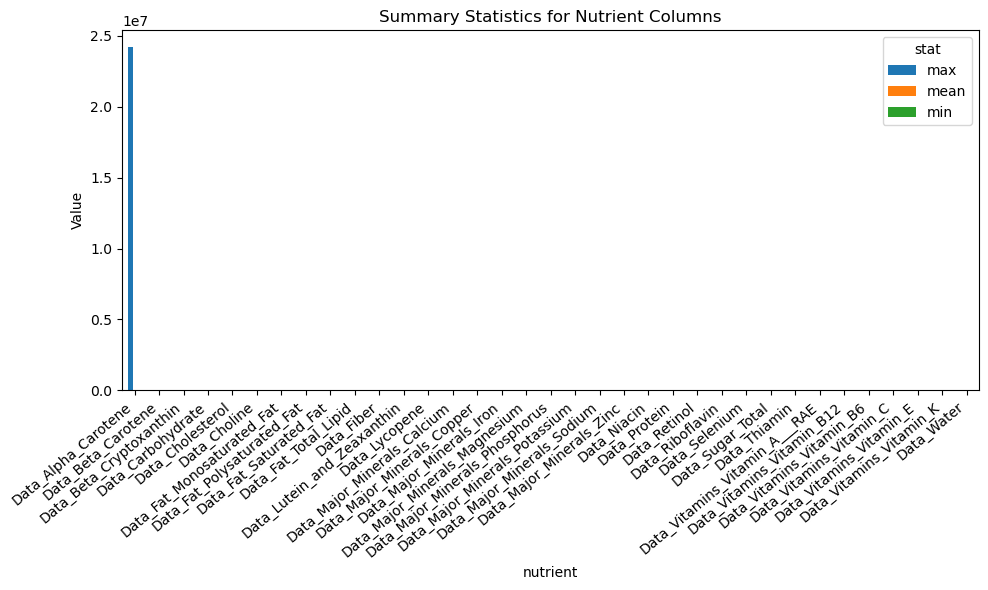

In [7]:
# Pivot dataframe for plotting
pivot = summary_pd.pivot(index='nutrient', columns='stat', values='value')

# Plot bar chart for nutrient summary statistics
pivot.plot(kind='bar', figsize=(10, 6))
plt.ylabel('Value')
plt.title('Summary Statistics for Nutrient Columns')
plt.xticks(rotation=40, ha='right')
plt.tight_layout()
plt.show()

In [8]:
# Select top 5 relevant nutrients (Vitamin, Protein, Carbohydrate)
selected_cols = [
    c for c in df.columns
    if any(x in c for x in ["Vitamin", "Protein", "Carbohydrate"])
][:5]

# Summary stats for selected columns
summary_selected = df.agg(
    *[F.mean(c).alias(f"{c}_mean") for c in selected_cols],
    *[F.min(c).alias(f"{c}_min") for c in selected_cols],
    *[F.max(c).alias(f"{c}_max") for c in selected_cols]
)
summary_selected.show()

+----------------------+-----------------+----------------------------------+------------------------------+-----------------------------+---------------------+----------------+---------------------------------+-----------------------------+----------------------------+---------------------+----------------+---------------------------------+-----------------------------+----------------------------+
|Data_Carbohydrate_mean|Data_Protein_mean|Data_Vitamins_Vitamin_A___RAE_mean|Data_Vitamins_Vitamin_B12_mean|Data_Vitamins_Vitamin_B6_mean|Data_Carbohydrate_min|Data_Protein_min|Data_Vitamins_Vitamin_A___RAE_min|Data_Vitamins_Vitamin_B12_min|Data_Vitamins_Vitamin_B6_min|Data_Carbohydrate_max|Data_Protein_max|Data_Vitamins_Vitamin_A___RAE_max|Data_Vitamins_Vitamin_B12_max|Data_Vitamins_Vitamin_B6_max|
+----------------------+-----------------+----------------------------------+------------------------------+-----------------------------+---------------------+----------------+-----------------

In [9]:
# Convert to Pandas for plotting
summary_pd = summary_selected.toPandas().T
summary_pd.columns = ['value']
summary_pd = summary_pd.reset_index()
summary_pd.rename(columns={'index': 'metric'}, inplace=True)
summary_pd['stat'] = summary_pd['metric'].str.split('_').str[-1]
summary_pd['nutrient'] = summary_pd['metric'].apply(lambda x: "_".join(x.split("_")[:-1]))
pivot = summary_pd.pivot(index='nutrient', columns='stat', values='value')

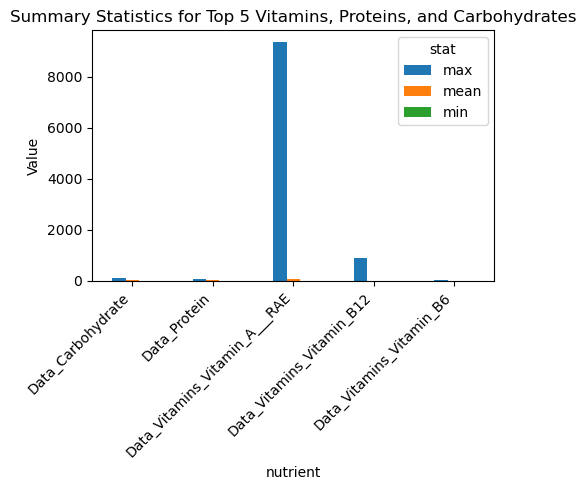

In [10]:
# Plot bar chart
pivot.plot(kind='bar', figsize=(5, 5))
plt.ylabel('Value')
plt.title('Summary Statistics for Top 5 Vitamins, Proteins, and Carbohydrates')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

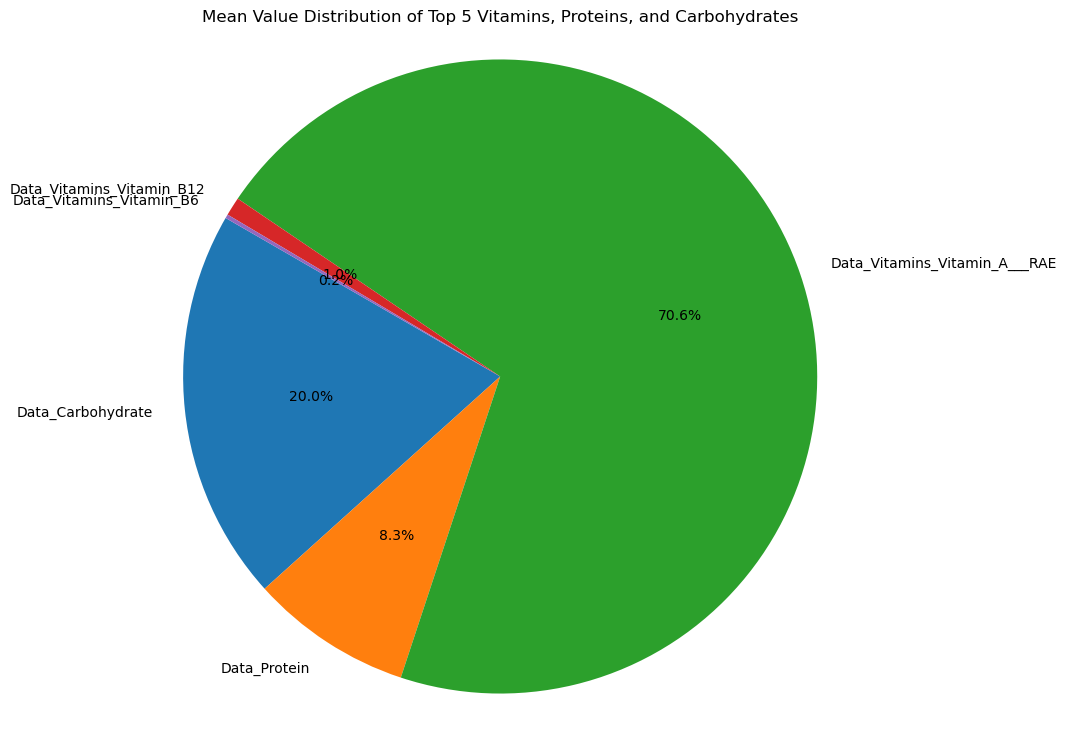

In [11]:
# Pie chart of mean distribution for selected nutrients
mean_values = pivot['mean']
plt.figure(figsize=(9, 9))
plt.pie(mean_values, labels=mean_values.index, autopct='%1.1f%%', startangle=150)
plt.title('Mean Value Distribution of Top 5 Vitamins, Proteins, and Carbohydrates')
plt.axis('equal')
plt.show()

In [12]:
# 4. Highest and lowest values for selected nutrients
for col in selected_cols:
    print(f"\nHighest {col}:")
    df_clean.orderBy(df_clean[col].desc()).limit(1).show()
    print(f"Lowest {col}:")
    df_clean.orderBy(df_clean[col].asc()).limit(1).show()




Highest Data_Carbohydrate:
+----------------+--------------------+-------------------------+-------------------+------------------+-----------------------+-----------------+----------------+------------+----------+--------------------------+-------------+-----------+------------+------------+---------------+-------------+----------------+------------+----------+--------------------------+--------------------------+----------------------+--------------------+---------------------------+--------------------------+------------------------+-----------------------------+------------------------------+-----------------------------+--------------------------+------------------------+-----------------------------+-------------------------+------------------------+-----------------------+-----------------------+-----------------------+
|        Category|         Description|Nutrient_Data_Bank_Number|Data_Alpha_Carotene|Data_Beta_Carotene|Data_Beta_Cryptoxanthin|Data_Carbohydrate|Data_Cholester

In [14]:
# 5. Specialized food recommendations

# High-protein foods (top 10)
print("=========== High Protein Food (top 10) ==============")
df_clean.orderBy(df_clean['Data_Protein'].desc()).limit(10).show()

# Diabetes-friendly foods: low carbohydrates and sugars (top 10)
print("=========== Diabetes-friendly foods: low carbohydrates and sugars (top 10) ==============")
df_clean.orderBy(
    df_clean['Data_Carbohydrate'],
    df_clean['Data_Sugar_Total']
).limit(10).show()

# Bone health: high calcium and vitamin K (top 10)
print("=============== Bone health: high calcium and vitamin K (top 10) ====================")
df_clean.orderBy(
    df_clean['Data_Protein'].desc(),
    df_clean['Data_Vitamins_Vitamin_K'].desc()
).limit(10).show()

# Heart health: low saturated fat, high fiber, high monounsaturated fat (top 10)
print("================ Heart health: low saturated fat, high fiber, high omega-3 (top 10) ==================")
df_clean.orderBy(
    df_clean['Data_Fat_Saturated_Fat'],
    df_clean['Data_Fiber'].desc(),
    df_clean['Data_Fat_Monosaturated_Fat'].desc()
).limit(10).show()

=========== High Protein Food (top 10) ==============
+--------------------+--------------------+-------------------------+-------------------+------------------+-----------------------+-----------------+----------------+------------+----------+--------------------------+-------------+-----------+------------+------------+---------------+-------------+----------------+------------+----------+--------------------------+--------------------------+----------------------+--------------------+---------------------------+--------------------------+------------------------+-----------------------------+------------------------------+-----------------------------+--------------------------+------------------------+-----------------------------+-------------------------+------------------------+-----------------------+-----------------------+-----------------------+
|            Category|         Description|Nutrient_Data_Bank_Number|Data_Alpha_Carotene|Data_Beta_Carotene|Data_Beta_Cryptoxanthi

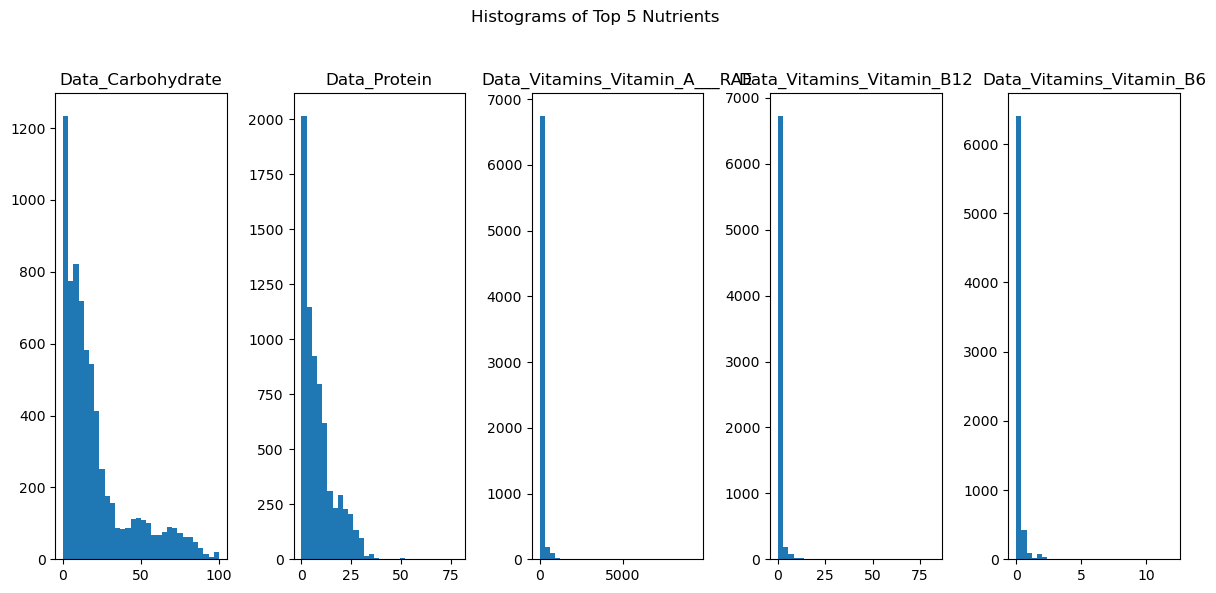

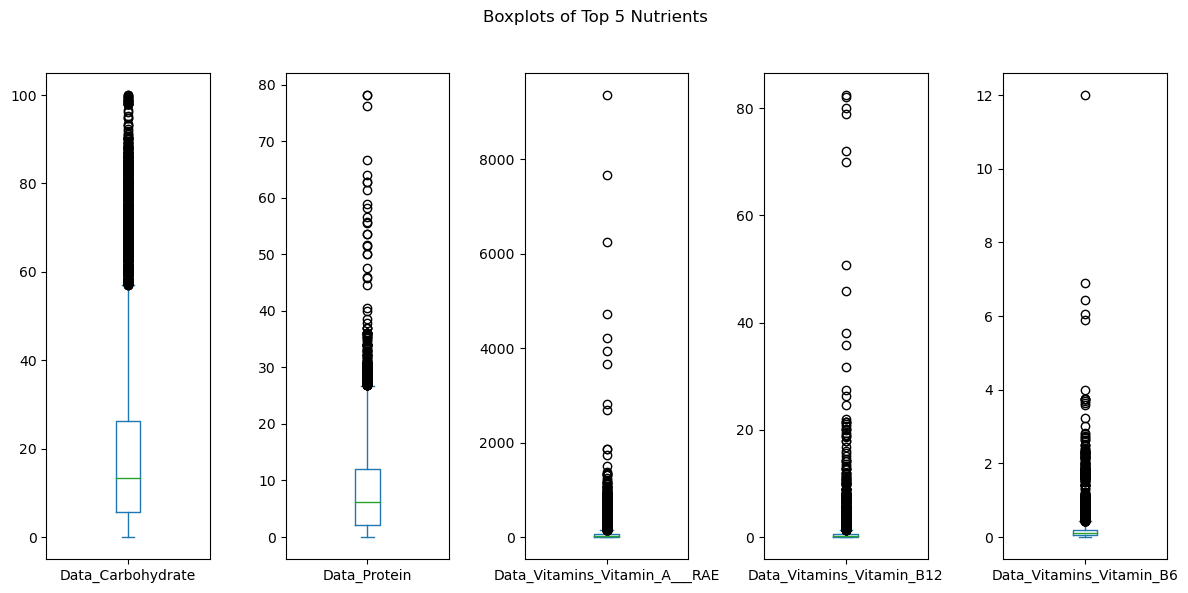

In [13]:
# Histograms and boxplots for selected nutrients
df_plot = df_clean.select(selected_cols).toPandas()

df_plot.hist(bins=30, figsize=(12, 6), layout=(1, 5), grid=False)
plt.suptitle('Histograms of Top 5 Nutrients')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

df_plot.plot(kind='box', subplots=True, layout=(1, 5), figsize=(12, 6), sharey=False)
plt.suptitle('Boxplots of Top 5 Nutrients')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [14]:
# 6. Machine Learning Analysis

# Feature selection (Vitamin, Protein, Carbohydrate, Fat, Fiber)
features = [c for c in df.columns if any(x in c for x in ["Vitamin", "Protein", "Carbohydrate", "Fat", "Fiber"])]

assembler = VectorAssembler(inputCols=features, outputCol="features")
df_features = assembler.transform(df).select("features")

# KMeans clustering (k=4)
kmeans = KMeans(k=4, seed=42)
model = kmeans.fit(df_features)
clusters = model.transform(df_features)

print("✅ Clustered Foods")
clusters.show(5, truncate=False)

# Find similar foods by Euclidean distance to the first food item
from pyspark.ml.linalg import Vectors

target = df_features.limit(1).collect()[0]["features"]
similar = (df_features.rdd
           .map(lambda row: (float(Vectors.squared_distance(row["features"], target)), row["features"]))
           .sortByKey()
           .take(6))

print("\n✅ Top 5 similar foods:")
for dist, feats in similar[1:]:
    print(f"Distance={dist:.4f}, Features={feats}")

# Correlation matrix of nutrient features
vector_df = assembler.transform(df).select("features")
corr_matrix = Correlation.corr(vector_df, "features").head()[0]
corr_array = corr_matrix.toArray()
print("\n✅ Correlation matrix shape:", corr_array.shape)
print(corr_array)

✅ Clustered Foods
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|features                                                                                                                                                                                                                        |prediction|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|[6.889999866485596,0.0,1.0299999713897705,1.6579999923706055,0.4970000088214874,2.009000062942505,4.380000114440918,61.0,0.05000000074505806,0.010999999940395355,5.0,0.07999999821186066,0.30000001192092896]                  |0         |
|[4.869999885559082,0.0,3.3399

DataFrame[Category: string, Description: string, Nutrient_Data_Bank_Number: string, Data_Alpha_Carotene: float, Data_Beta_Carotene: float, Data_Beta_Cryptoxanthin: float, Data_Carbohydrate: float, Data_Cholesterol: float, Data_Choline: float, Data_Fiber: float, Data_Lutein_and_Zeaxanthin: float, Data_Lycopene: float, Data_Niacin: float, Data_Protein: float, Data_Retinol: float, Data_Riboflavin: float, Data_Selenium: float, Data_Sugar_Total: float, Data_Thiamin: float, Data_Water: float, Data_Fat_Monosaturated_Fat: float, Data_Fat_Polysaturated_Fat: float, Data_Fat_Saturated_Fat: float, Data_Fat_Total_Lipid: float, Data_Major_Minerals_Calcium: float, Data_Major_Minerals_Copper: float, Data_Major_Minerals_Iron: float, Data_Major_Minerals_Magnesium: float, Data_Major_Minerals_Phosphorus: float, Data_Major_Minerals_Potassium: float, Data_Major_Minerals_Sodium: float, Data_Major_Minerals_Zinc: float, Data_Vitamins_Vitamin_A___RAE: float, Data_Vitamins_Vitamin_B12: float, Data_Vitamins_Vitam

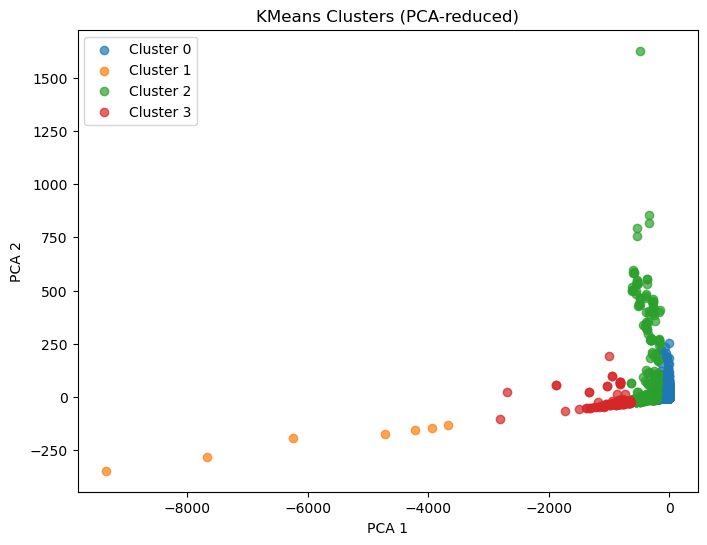

In [15]:
# 7. Cluster visualization with PCA

# Add row IDs to align DataFrames
df_with_id = df.withColumn("row_id", monotonically_increasing_id())
df_features_with_id = df_features.withColumn("row_id", monotonically_increasing_id())
clusters_with_id = clusters.withColumn("row_id", monotonically_increasing_id())

# Join cluster assignments to the original DataFrame
df_with_clusters = (
    df_with_id
    .join(clusters_with_id.select("row_id", "prediction"), on="row_id")
    .drop("row_id")
    .withColumnRenamed("prediction", "cluster")
)

display(df_with_clusters)

# 2D visualization using PCA
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df_features)
df_pca = pca_model.transform(df_features_with_id)

# Join cluster assignments to PCA DataFrame
df_pca = (
    df_pca
    .join(clusters_with_id.select("row_id", "prediction"), on="row_id")
    .withColumnRenamed("prediction", "cluster")
)

# Convert to Pandas for matplotlib plotting
pdf = df_pca.select("pca_features", "cluster").toPandas()
pdf["x"] = pdf["pca_features"].apply(lambda v: v[0])
pdf["y"] = pdf["pca_features"].apply(lambda v: v[1])

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
for cluster in sorted(pdf["cluster"].unique()):
    subset = pdf[pdf["cluster"] == cluster]
    plt.scatter(subset["x"], subset["y"], label=f"Cluster {cluster}", alpha=0.7)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("KMeans Clusters (PCA-reduced)")
plt.legend()
plt.show()

In [23]:
# Use only selected nutrient columns, e.g., top 5
selected_cols = [
    c for c in df.columns
    if any(x in c for x in ["Vitamin", "Protein", "Carbohydrate"])
][:5]

# Convert to RDD of Rows
rdd_rows = df.select(*selected_cols).rdd


In [24]:
# Convert each row to tuple of floats
rdd_tuples = rdd.map(lambda row: tuple(float(x) if x is not None else 0 for x in row))

# Compute column-wise min and max using reduce
min_values = rdd_tuples.reduce(lambda x, y: tuple(min(a,b) for a,b in zip(x,y)))
max_values = rdd_tuples.reduce(lambda x, y: tuple(max(a,b) for a,b in zip(x,y)))

print("Mins:", min_values)
print("Maxs:", max_values)


Mins: (0.0, 0.0, 0.0, 0.0, 0.0)
Maxs: (100.0, 78.12999725341797, 9363.0, 879.0, 14.0)


In [25]:
def normalize(row):
    normalized = []
    for i, val in enumerate(row):
        if max_values[i] != min_values[i]:
            norm_val = (val - min_values[i]) / (max_values[i] - min_values[i])
        else:
            norm_val = 0.0  # Handle constant columns
        normalized.append(norm_val)
    return tuple(normalized)

rdd_normalized = rdd_tuples.map(normalize)


In [26]:
from pyspark.sql.types import StructType, StructField, FloatType

# Define schema with FloatType for each selected column
schema = StructType([StructField(col, FloatType(), True) for col in selected_cols])

# Create DataFrame with schema
normalized_df = spark.createDataFrame(rdd_rows, schema)

normalized_df.show(5)


+-----------------+------------+-----------------------------+-------------------------+------------------------+
|Data_Carbohydrate|Data_Protein|Data_Vitamins_Vitamin_A___RAE|Data_Vitamins_Vitamin_B12|Data_Vitamins_Vitamin_B6|
+-----------------+------------+-----------------------------+-------------------------+------------------------+
|             6.89|        1.03|                         61.0|                     0.05|                   0.011|
|             4.87|        3.34|                         59.0|                     0.56|                    0.06|
|             4.67|        3.28|                         32.0|                     0.54|                   0.061|
|             4.46|         3.1|                         29.0|                     0.36|                   0.034|
|             4.67|        3.28|                         32.0|                     0.54|                   0.061|
+-----------------+------------+-----------------------------+-------------------------+

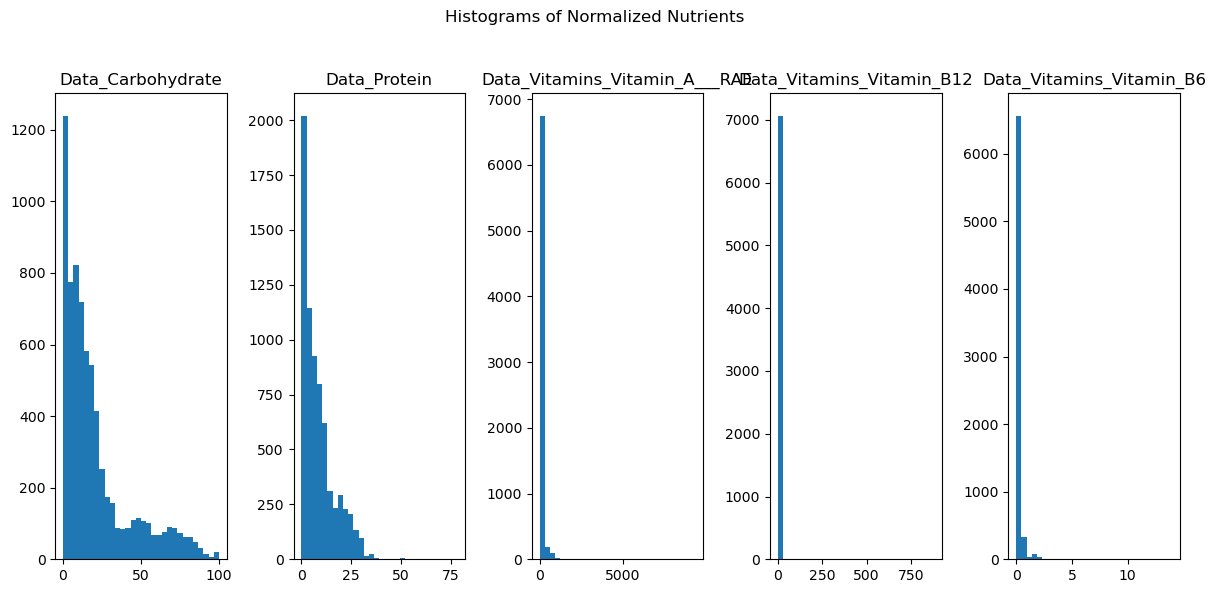

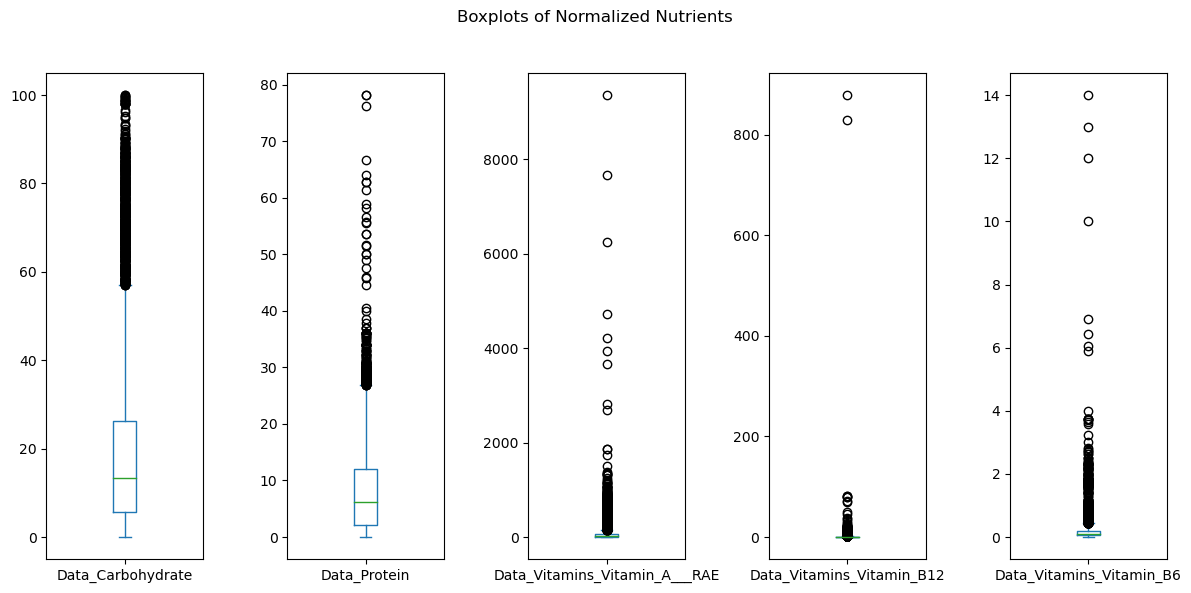

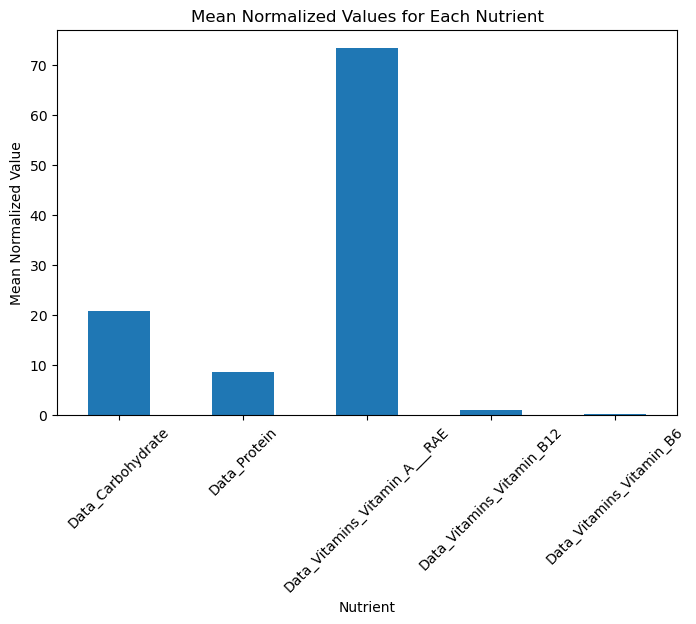

In [27]:
normalized_pd = normalized_df.toPandas()
import matplotlib.pyplot as plt

# Histograms - show distribution of each nutrient
normalized_pd.hist(bins=30, figsize=(12, 6), layout=(1, 5), grid=False)
plt.suptitle('Histograms of Normalized Nutrients')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Boxplots to show spread and outliers
normalized_pd.plot(kind='box', subplots=True, layout=(1, 5), figsize=(12, 6), sharey=False)
plt.suptitle('Boxplots of Normalized Nutrients')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Bar plot of mean normalized values per nutrient
mean_values = normalized_pd.mean()
mean_values.plot(kind='bar', figsize=(8, 5))
plt.title('Mean Normalized Values for Each Nutrient')
plt.ylabel('Mean Normalized Value')
plt.xlabel('Nutrient')
plt.xticks(rotation=45)
plt.show()

